### [GD_10] 나를 찾아줘 - Class Activation Map 만들기

##### 0. 라이브러리 로드

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 1. 데이터셋 로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

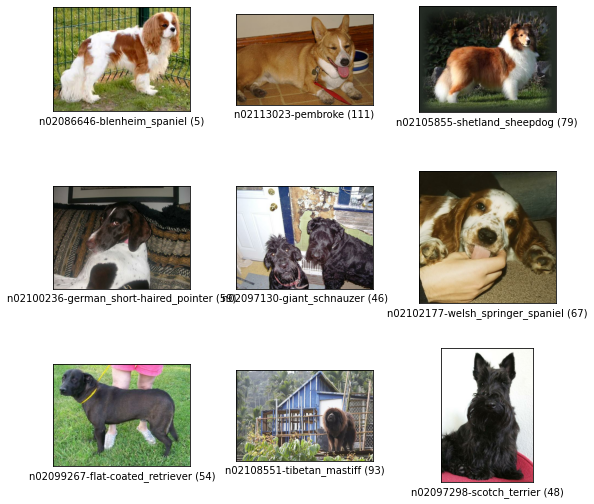

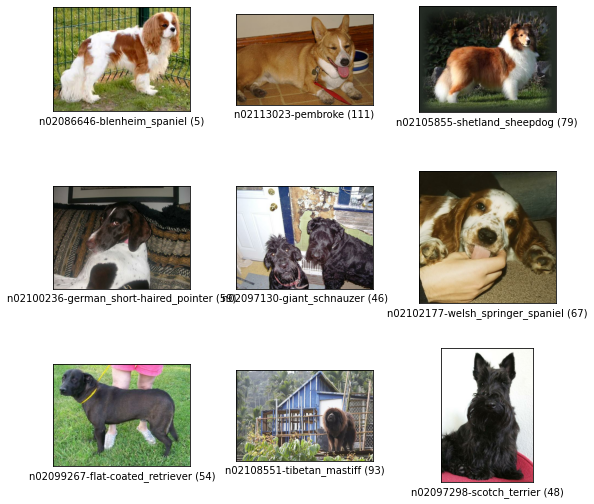

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
image_width = 224
image_height = 224
batch_size = 16
shuffle_size = 200

##### 2. 전처리

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(input['image'], (image_width, image_height))
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2,
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(shuffle_size)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
def get_one(ds):
    ds = ds.take(1)
    item = list(ds.as_numpy_iterator())[0]
#     bbox = item['objects']['bbox']
#     image = item['image']
#     label = item['label']
    return item

116


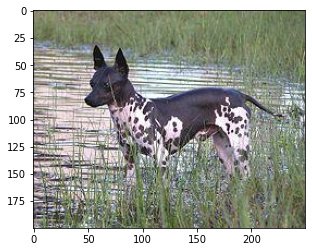

In [10]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()


##### 3. 학습 모델 생성.

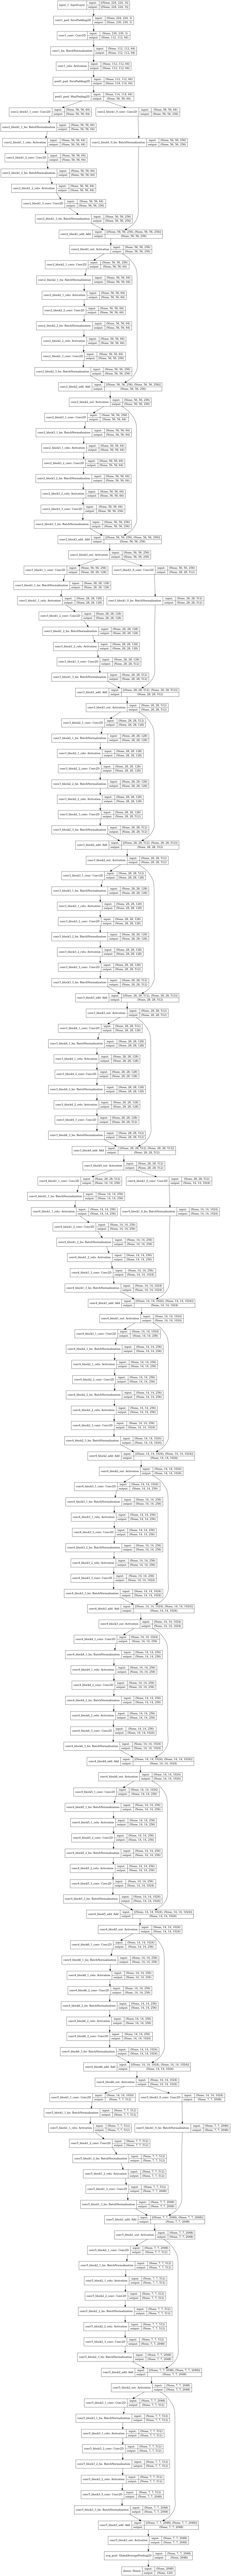

In [11]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

from tensorflow.keras.utils import plot_model

plot_model(cam_model, show_shapes=True, show_layer_names=True, expand_nested=True, show_dtype=False)


##### 4. CAM

In [12]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]    
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    print("conv output:", conv_outputs.shape, " predic:", predictions.shape)
    
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    last_layer = model.layers[-1]
    class_weights = last_layer.get_weights()[0]
    print('last_layer:', last_layer.name, ' weight:', class_weights.shape)
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    cls_weight = class_weights[:, class_idx]
    print('cls_weight:', cls_weight.shape)
    
    for i, w in enumerate(cls_weight):
        # 활성화정도는 conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image) # normalize activation score 
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

conv output: (1, 7, 7, 2048)  predic: (1, 120)
last_layer: dense  weight: (2048, 120)
cls_weight: (2048,)


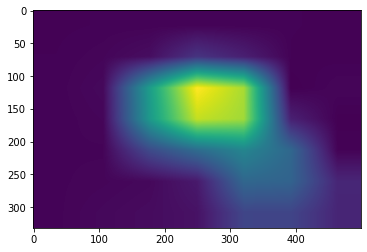

In [13]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [14]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

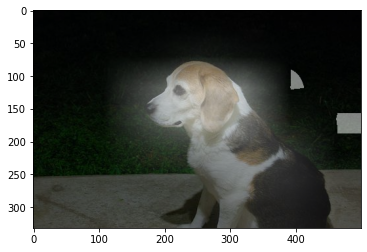

In [15]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

##### 5. grad-CAM

In [16]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]
        
    # gradient GAP으로 weight를 구함.
    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


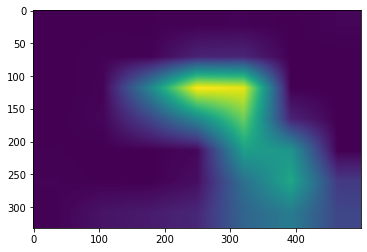

In [17]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

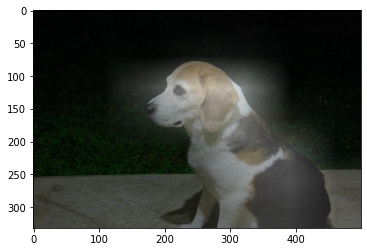

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

##### 6. BoundingBox detect

In [19]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    
    cam_image = (cam_image * 255).astype(np.uint8)
    
    # 등고선 검출.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
    
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int32(rect)
    
    print(len(contours), contours[0].shape)
    image = copy.deepcopy(cam_image)
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 5)

    # show thresh applied img
    plt.imshow(image)
    plt.show()
    

    return rect

1 (182, 1, 2)


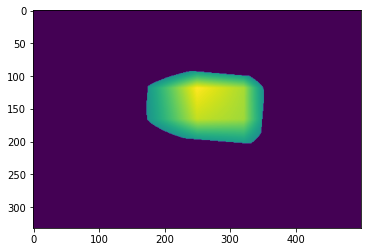

[[165 193]
 [174  83]
 [358  99]
 [349 208]]


In [20]:
rect = get_bbox(cam_image, 0.5)
print(rect)

In [24]:
from PIL import Image, ImageDraw

def box_image(image, rect):
    image2 = copy.deepcopy(image)
    image2 = cv2.line(image2, rect[0], rect[1], (255, 0, 0), 2)
    image2 = cv2.line(image2, rect[1], rect[2], (255, 0, 0), 2)
    image2 = cv2.line(image2, rect[2], rect[3], (255, 0, 0), 2)
    image2 = cv2.line(image2, rect[3], rect[0], (255, 0, 0), 2)
    return image2


In [84]:
rotated_rect

((83.19999694824219, 60.900001525878906),
 (83.16788482666016, 66.72406005859375),
 18.43494987487793)

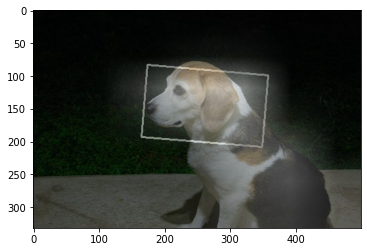

In [25]:
origin_image = item['image'].astype(np.uint8)
rect_image = box_image(grad_cam_image*255, rect)

box_image_3channel = np.stack([rect_image]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(box_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [26]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [27]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.25, 0.33, 0.6265060240963856, 0.716]

##### 7. IoU

In [28]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


In [29]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.32070451809283085

##### 8. 회고  

- 모델의 출력 layer와 가중치를 바탕으로 CAM, grad-CAM을 구현해보았다.  
- 초기 레이어일 수록 feature가 작고 단편적이었다면, 출력층 쪽의 레이어를 사용하면,   
     더 의미가 있는 형태의 CAM을 확인할 수 있었다.  
- 모델의 성능을 확인할때 특징을 얼마나 잘 찾고 있는지를 간접적으로 확인할 수 있었다.  
- cv2를 사용하여 후처리를 하는 경우 Bbox와 같은 추가 정보도 얻을 수 있다.  